In [2]:
!pip install livelossplot

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tempfile
import requests
import joblib
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import  Embedding, Dense, GRU, LSTM, Activation
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import mixed_precision
from livelossplot.tf_keras import PlotLossesCallback
np.random.seed(0)
plt.style.use("ggplot")

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
dataset_path = "Dataset/ner_dataset.csv"
data = pd.read_csv(dataset_path, encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [6]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
batch_size=64
epochs=3
#enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [7]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [8]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [10]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

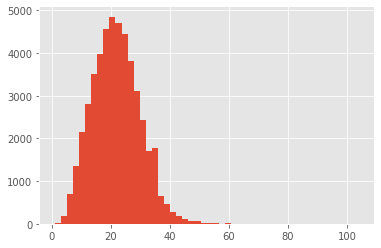

In [12]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [13]:
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# LSTM

In [27]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)(model)
model = TimeDistributed(Dense(num_tags))(model)
out =   Activation('softmax', dtype='float32', name='predictions')(model)
model = Model(input_word, out)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 17)            1717      
_________________________________________________________________
predictions (Activation)     (None, 50, 17)            0         
Total params: 1,821,067
Trainable params: 1,821,067
Non-trainable params: 0
_________________________________________________

In [28]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

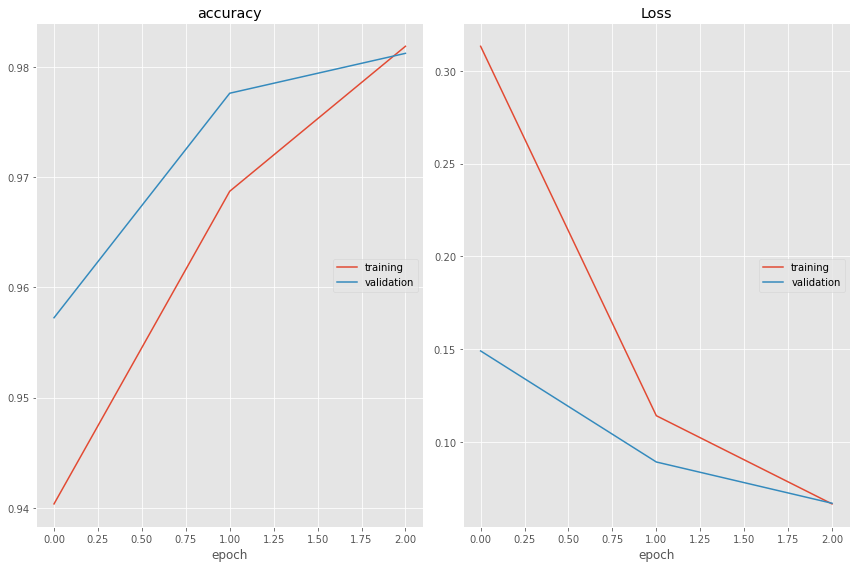

accuracy
	training         	 (min:    0.940, max:    0.982, cur:    0.982)
	validation       	 (min:    0.957, max:    0.981, cur:    0.981)
Loss
	training         	 (min:    0.067, max:    0.313, cur:    0.067)
	validation       	 (min:    0.067, max:    0.149, cur:    0.067)
CPU times: user 8min 19s, sys: 57.7 s, total: 9min 17s
Wall time: 6min 24s


In [29]:
%%time

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

In [30]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 5s 16ms/step - loss: 0.0671 - accuracy: 0.9812


[0.06708197295665741, 0.9812218546867371]

# GRU

In [31]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = GRU(units=100, return_sequences=True, recurrent_dropout=0.1)(model)
model = TimeDistributed(Dense(num_tags))(model)
out =   Activation('softmax', dtype='float32', name='predictions')(model)
model = Model(input_word, out)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 50, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 100)           45600     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 50, 17)            1717      
_________________________________________________________________
predictions (Activation)     (None, 50, 17)            0         
Total params: 1,806,267
Trainable params: 1,806,267
Non-trainable params: 0
_________________________________________________

In [32]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

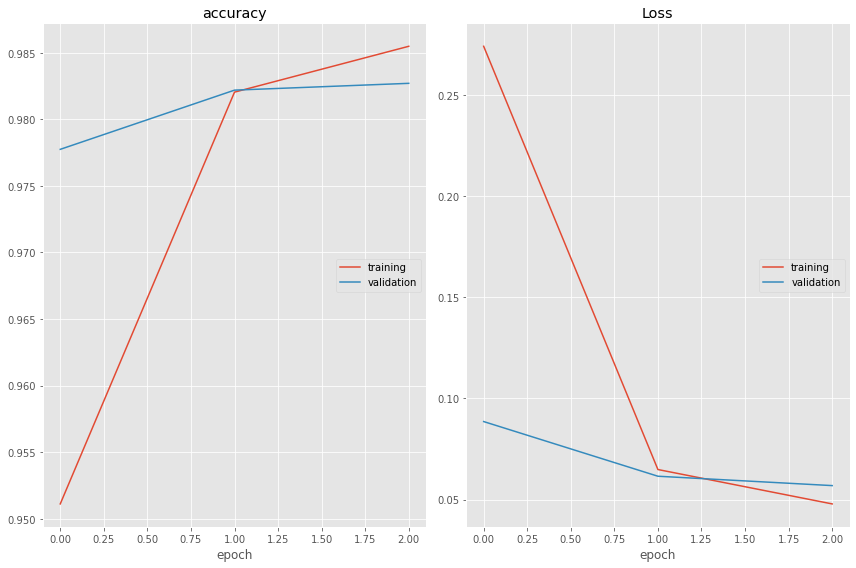

accuracy
	training         	 (min:    0.951, max:    0.985, cur:    0.985)
	validation       	 (min:    0.978, max:    0.983, cur:    0.983)
Loss
	training         	 (min:    0.048, max:    0.274, cur:    0.048)
	validation       	 (min:    0.057, max:    0.089, cur:    0.057)
CPU times: user 7min 43s, sys: 51.7 s, total: 8min 34s
Wall time: 5min 26s


In [33]:
%%time

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

In [34]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 6s 19ms/step - loss: 0.0569 - accuracy: 0.9827


[0.05690917372703552, 0.9827022552490234]

## Bidirectional GRU

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(GRU(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(num_tags))(model)
out =   Activation('softmax', dtype='float32', name='predictions')(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           91200     
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
_________________________________________________________________
predictions (Activation)     (None, 50, 17)            0         
Total params: 1,853,567
Trainable params: 1,853,567
Non-trainable params: 0
___________________________________________________

In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

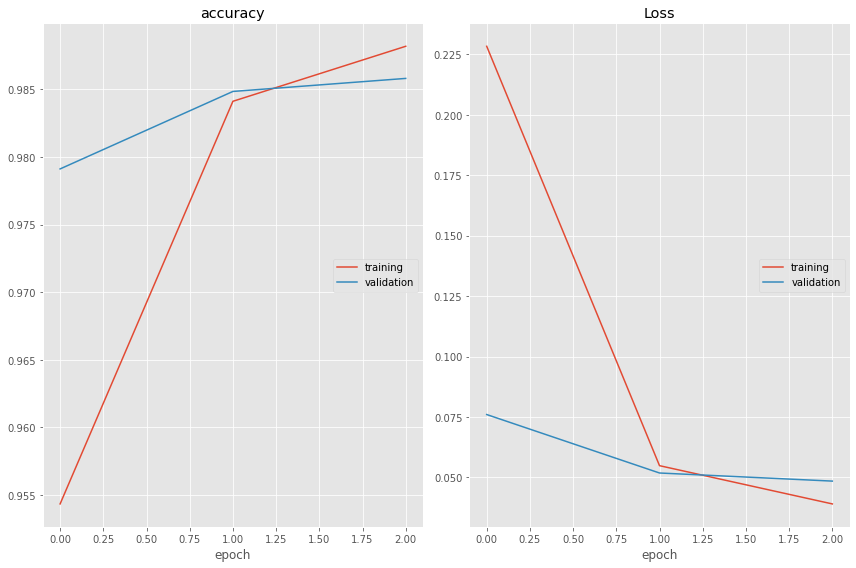

accuracy
	training         	 (min:    0.954, max:    0.988, cur:    0.988)
	validation       	 (min:    0.979, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.039, max:    0.228, cur:    0.039)
	validation       	 (min:    0.048, max:    0.076, cur:    0.048)
CPU times: user 14min 20s, sys: 1min 42s, total: 16min 3s
Wall time: 10min 26s


In [17]:
%%time

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

In [18]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 9s 31ms/step - loss: 0.0485 - accuracy: 0.9858


[0.04846225306391716, 0.985806941986084]

# Bidirectional LSTM

In [21]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(num_tags))(model)
out =   Activation('softmax', dtype='float32', name='predictions')(model)
model = Model(input_word, out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
_________________________________________________________________
predictions (Activation)     (None, 50, 17)            0         
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________

In [22]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

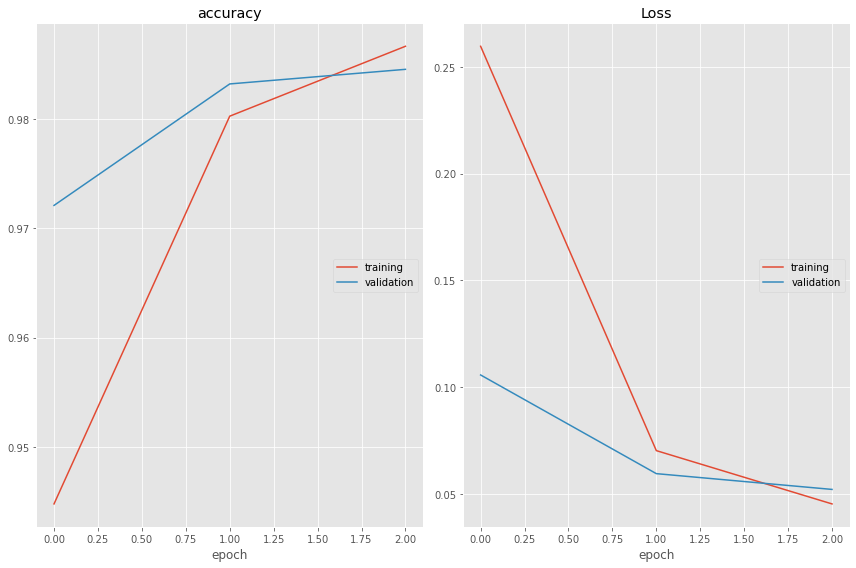

accuracy
	training         	 (min:    0.945, max:    0.987, cur:    0.987)
	validation       	 (min:    0.972, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.045, max:    0.260, cur:    0.045)
	validation       	 (min:    0.052, max:    0.106, cur:    0.052)
CPU times: user 15min 21s, sys: 1min 51s, total: 17min 12s
Wall time: 10min 16s


In [23]:
%%time

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

In [24]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 9s 28ms/step - loss: 0.0523 - accuracy: 0.9845


[0.052270930260419846, 0.9845183491706848]

# Inference

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
U.S.           B-geo	B-geo
officials      O	O
have           O	O
ordered        O	O
a              O	O
recall         O	O
of             O	O
143            O	O
million        O	O
pounds         O	O
of             O	O
beef           O	O
produced       O	O
by             O	O
a              O	O
California     B-org	B-geo
processor      O	O
accused        O	O
of             O	O
violating      O	O
food           O	O
safety         O	O
regulations    O	O
,              O	O
in             O	O
the            O	O
largest        O	O
recall         O	O
in             O	O
U.S.           B-geo	B-geo
history        O	O
.              O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chabanenko     O	O
Chaba